# Topic Analyse <div class="tocSkip">

Das Ziel dieses Notebooks ist es, anhand Topic-Analyse Themenstrukturen zu identifizieren.

## Hilfsfunktionen und Einstellungen <div class="tocSkip">


In [1]:
%run "../lib/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Initialisierung

### Daten einlesen
Daten aus der Datenbank lesen und parsen der Date-Einträge

In [2]:
database = '../resources/bt_reden_final.sqlite'

sql = """
SELECT session_id ,speech_id, legislative_period, 
  speaker || '. ' || affiliation || '. ' || text as text, 
  clean_text, adjs_verbs, nouns, session_date,entities
FROM bt_reden_prepared
WHERE strftime('%Y%m%d', session_date)
"""
con = sqlite3.connect(database)
df = pd.read_sql_query(sql, con, parse_dates=['session_date'])
con.close()

In [3]:
pd.set_option('max_colwidth', -1)

df.sample(5)

# reset display column width to 30
pd.reset_option('max_colwidth')
df.head(3
       )

session_id     speech_id  legislative_period  \
18513  36          ID193613600   19                   
20826  170         ID1917002200  19                   
1177   99          ID199900300   19                   
14911  91          ID199100600   19                   
7265   164         ID1916402500  19                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

,session_id,speech_id,legislative_period,text,clean_text,adjs_verbs,nouns,session_date,entities
0,43,ID194300100,19,Olaf Scholz. Bundesminister BMF. Herr Präsiden...,Griechenland Hilfsprogramm planmäßig 20. Augus...,20. beenden verlassen stehen anschließen europ...,Griechenland Hilfsprogramm August Griechenland...,2018-06-29,Griechenland/LOC Griechenland/LOC Europäischen...
1,43,ID194300200,19,Peter Boehringer. AfD. Herr Präsident! Liebe K...,heutig Vorlage stehen 480 Seite eigentlich Gri...,stehen bekommen fällige liegen verzichten denk...,Vorlage Seite Griechenland Finanzspritze Milli...,2018-06-29,Griechenland/LOC Milliardenhöhe/ORG Deutschlan...
2,43,ID194300300,19,Eckhardt Rehberg. CDU/CSU. Herr Präsident! Lie...,Griechenland letzt Revue passieren lassen fall...,passieren lassen fallen bringen refinanzieren ...,Rede Griechenland Revue Aussage Irland Portuga...,2018-06-29,Griechenland/LOC Irland/LOC Portugal/LOC Spani...


In [4]:
df.reset_index(drop=True, inplace=True)

### Liste mit eingenen Stoppwörtern

In [5]:
stop_words = """
Fraktion Montag Dienstag Mittwoch Donnerstag Freitag Samstag Sonntag Gesetzentwurf
Jahr Monat Tag Woche Uhr Zeit Angabe Haus Fall Kind Mann Frau Mensch Problem
Ende Prozent Million Milliarde Zahl Angabe Stadt Debatte Dr Präsidentin Frage Antrag Deutschland Wort Thema Gesetz Redner Stelle Land Punkt Datum
""".strip().split()

## Vektorisierung


### TF-Matrix (Counts)


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1, 1), 
                             
                             lowercase=False,
                             stop_words=stop_words)

X_tf = count_vect.fit_transform(df['nouns'])

type(X_tf)
X_tf.shape

scipy.sparse.csr.csr_matrix

(24647, 127172)

### Werte für `min_df` und `max_df` ermitteln


In [7]:
# document frequencies aus X_tf berechnen:
# zähle pro Spalte die Anzahl der Einträge > 0
doc_freqs = np.asarray((X_tf > 0).sum(axis=0)).flatten()

# wandle den Vektor in in Dictionary um, mit den Worten als Keys
doc_freqs = dict(zip(count_vect.get_feature_names(), doc_freqs))

In [8]:
# ermittle analog ein Dictionary mit den Word-Counts (Spaltensummen in X_tf)
counts = np.asarray(X_tf.sum(axis=0)).flatten()
counts = dict(zip(count_vect.get_feature_names(), counts))

# Transformiere in einen Data Frame mit Term Freq und Doc Freq
count_df = pd.DataFrame.from_dict(counts, orient='index', columns=['freq'])
count_df['df_abs'] = count_df.index.map(doc_freqs) # absolute df
count_df['df_rel'] = count_df['df_abs'] / X_tf.shape[0] # relative df --> max_df-Wert
count_df.sort_values(by='df_rel', ascending=False, inplace=True)
count_df.index.name = 'token'

In [9]:
pd.set_option('max_rows', 300)

count_df.head(100)

,freq,df_abs,df_rel
token,,,
Bundesregierung,12963,7395,0.30
CDU,8432,6845,0.28
SPD,9288,6734,0.27
CSU,7973,6588,0.27
AfD,9974,6407,0.26
Euro,16915,6337,0.26
FDP,8825,5744,0.23
Weg,8546,5598,0.23
Bereich,8027,4850,0.20


In [10]:
count_df.query("df_abs <= 4")

,freq,df_abs,df_rel
token,,,
Regentschaft,4,4,0.00
Quellensteuern,4,4,0.00
Fachfrau,4,4,0.00
Rückkehrabkommen,5,4,0.00
Feindlichkeit,4,4,0.00
...,...,...,...
Organisationsselbstständigkeit,1,1,0.00
Organisationsstandorte,1,1,0.00
Fremdsprachenübersetzung,1,1,0.00


Bei `min_df` merkt man, dass es  es viele Worte gibt, die sehr selten vorkommen. Daher deklarieren wir eine Schwelle >3 

In [11]:
# learn vocabulary for all data
count_vect = CountVectorizer(ngram_range=(1, 1), 
                             min_df=3, 
                             max_df=1.0, 
                             lowercase=False,
                             stop_words=stop_words)

# alternatively: only nouns or nouns+adjs+verbs
X_tf = count_vect.fit_transform(df['nouns'])

type(X_tf)
X_tf.shape

scipy.sparse.csr.csr_matrix

(24647, 39766)

In [12]:
id2word = {id: word for id, word in enumerate(count_vect.get_feature_names())}

### TF-IDF-Matrix


In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vect = TfidfTransformer()

X_tfidf = tfidf_vect.fit_transform(X_tf)

X_tfidf.shape

(24647, 39766)

## Topic-Analyse mit LDA


In [14]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10

lda = LatentDirichletAllocation(n_components=num_topics,  max_iter=5)
lda.fit(X_tf)

LatentDirichletAllocation(max_iter=5)

Die Funktion `show_topic` (inspiriert durch die gleichnamige `gensim`-Methode) gibt die Wahrscheinlichkeitsverteilung über die Terme innerhalb eines Topics aus.

In [15]:
def show_topic(model, feature_names, num_topic, n_top_words = -1):

    # Zeile mit Wahrscheinlichkeits zum Topic, 
    # normiert durch Division durch Zeilensumme
    prob = model.components_[num_topic]/model.components_[num_topic].sum()
    
    topic = []
    for i in prob.argsort()[:-n_top_words - 1:-1]:
        # Berechne Wahrscheinlichkeit für Term im Topic
        topic.append((feature_names[i], prob[i]))
        
    return topic

In [16]:
pp.pprint(show_topic(lda, count_vect.get_feature_names(), 0, 10))

[('Bundestag', 0.011222676911123402),
 ('Entscheidung', 0.00733941036549669),
 ('Maßnahme', 0.006124395246921591),
 ('Bürger', 0.005751971169735778),
 ('SPD', 0.005598401786568533),
 ('Parlament', 0.005591832057521594),
 ('AfD', 0.0054531766793778046),
 ('Bundesregierung', 0.005189971571534974),
 ('FDP', 0.0050173106781917064),
 ('Regelung', 0.004797130282105146)]


In [17]:
topic = show_topic(lda, count_vect.get_feature_names(), 0)
prob = 0
for i in range(len(topic)):
    prob += topic[i][1]
print("Insgesamt %.2f %%" % (prob*100))

Insgesamt 100.00 %


In [18]:
def print_topics(model, feature_names, n_top_words = 20):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [19]:
print_topics(lda, count_vect.get_feature_names(), 10)

Topic #0: Bundestag Entscheidung Maßnahme Bürger SPD Parlament AfD Bundesregierung FDP Regelung
Topic #1: Euro Unternehmen FDP Bundesregierung Energie Klimaschutz Ziel AfD SPD Weg
Topic #2: AfD Bundeswehr Bundesregierung Demokratie CDU Welt CSU SPD FDP Menschenrechte
Topic #3: Russland Bundesregierung Syrien Staat Iran Israel Wald CO2 Opfer USA
Topic #4: Einsatz Soldat Mandat Region EU Bundesregierung Mission Soldatinnen Bundeswehr Afghanistan
Topic #5: Europa EU Union Vertrag Bundesregierung Kommission China Welt Staat Mitgliedstaaten
Topic #6: Digitalisierung Bundesregierung Bereich Weg Zukunft Forschung Ministerin Innovation Chance FDP
Topic #7: Euro Wohnung Bundesregierung SPD CSU Bahn Mieter CDU Miete Bereich
Topic #8: Euro Haushalt Geld Familie Bund Schule Bereich Bildung FDP Zukunft
Topic #9: Euro Arbeit Unternehmen Weg Bereich Krise SPD Geld Maßnahme Rente



In [20]:
from IPython.display import display

def topics_table(model, feature_names, n_top_words = 20):
    
    # Aufbau eines DataFrames für die Anzeige
    word_dict = {}
    num_topics = model.n_components
    
    for i in range(num_topics):
        
        # ermittle für jedes Topic die größten Werte
        # und füge die entsprechenden Worte im Klartext dem Dictionary hinzu
        words_ids = model.components_[i].argsort()[:-n_top_words-1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic #%2d' % i] = words;
    
    display(pd.DataFrame(word_dict))

In [21]:
topics_table(lda, count_vect.get_feature_names())

,Topic # 0,Topic # 1,Topic # 2,Topic # 3,Topic # 4,Topic # 5,Topic # 6,Topic # 7,Topic # 8,Topic # 9
0,Bundestag,Euro,AfD,Russland,Einsatz,Europa,Digitalisierung,Euro,Euro,Euro
1,Entscheidung,Unternehmen,Bundeswehr,Bundesregierung,Soldat,EU,Bundesregierung,Wohnung,Haushalt,Arbeit
2,Maßnahme,FDP,Bundesregierung,Syrien,Mandat,Union,Bereich,Bundesregierung,Geld,Unternehmen
3,Bürger,Bundesregierung,Demokratie,Staat,Region,Vertrag,Weg,SPD,Familie,Weg
4,SPD,Energie,CDU,Iran,EU,Bundesregierung,Zukunft,CSU,Bund,Bereich
5,Parlament,Klimaschutz,Welt,Israel,Bundesregierung,Kommission,Forschung,Bahn,Schule,Krise
6,AfD,Ziel,CSU,Wald,Mission,China,Ministerin,Mieter,Bereich,SPD
7,Bundesregierung,AfD,SPD,CO2,Soldatinnen,Welt,Innovation,CDU,Bildung,Geld
8,FDP,SPD,FDP,Opfer,Bundeswehr,Staat,Chance,Miete,FDP,Maßnahme
9,Regelung,Weg,Menschenrechte,USA,Afghanistan,Mitgliedstaaten,FDP,Bereich,Zukunft,Rente


### Topics visualisieren


#### als Balkendiagramm

In [22]:
# Import und Einstellungen für das Balkendiagramm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.dpi"] = 100

def topic_barplot(model, feature_names, num_topic, n_top_words = 20): 

    # extrahiere die Listen für Topic-Namen und Werte als getrennte Listen
    labels, values = zip(*show_topic(model, feature_names, num_topic, n_top_words))
    
    dummy_pos = np.arange(len(labels))
    
    # Erstellung des Balkendiagramms
    fig=plt.figure(figsize=(10, 4))
    plt.bar(dummy_pos, values)
    plt.xticks(dummy_pos, labels,  rotation="vertical", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Term', fontsize=20)
    plt.ylabel('Wahrscheinlichkeit', fontsize=16)
    plt.title("Topic #%d, Top-%d Worte" % (num_topic, n_top_words), fontsize=16)

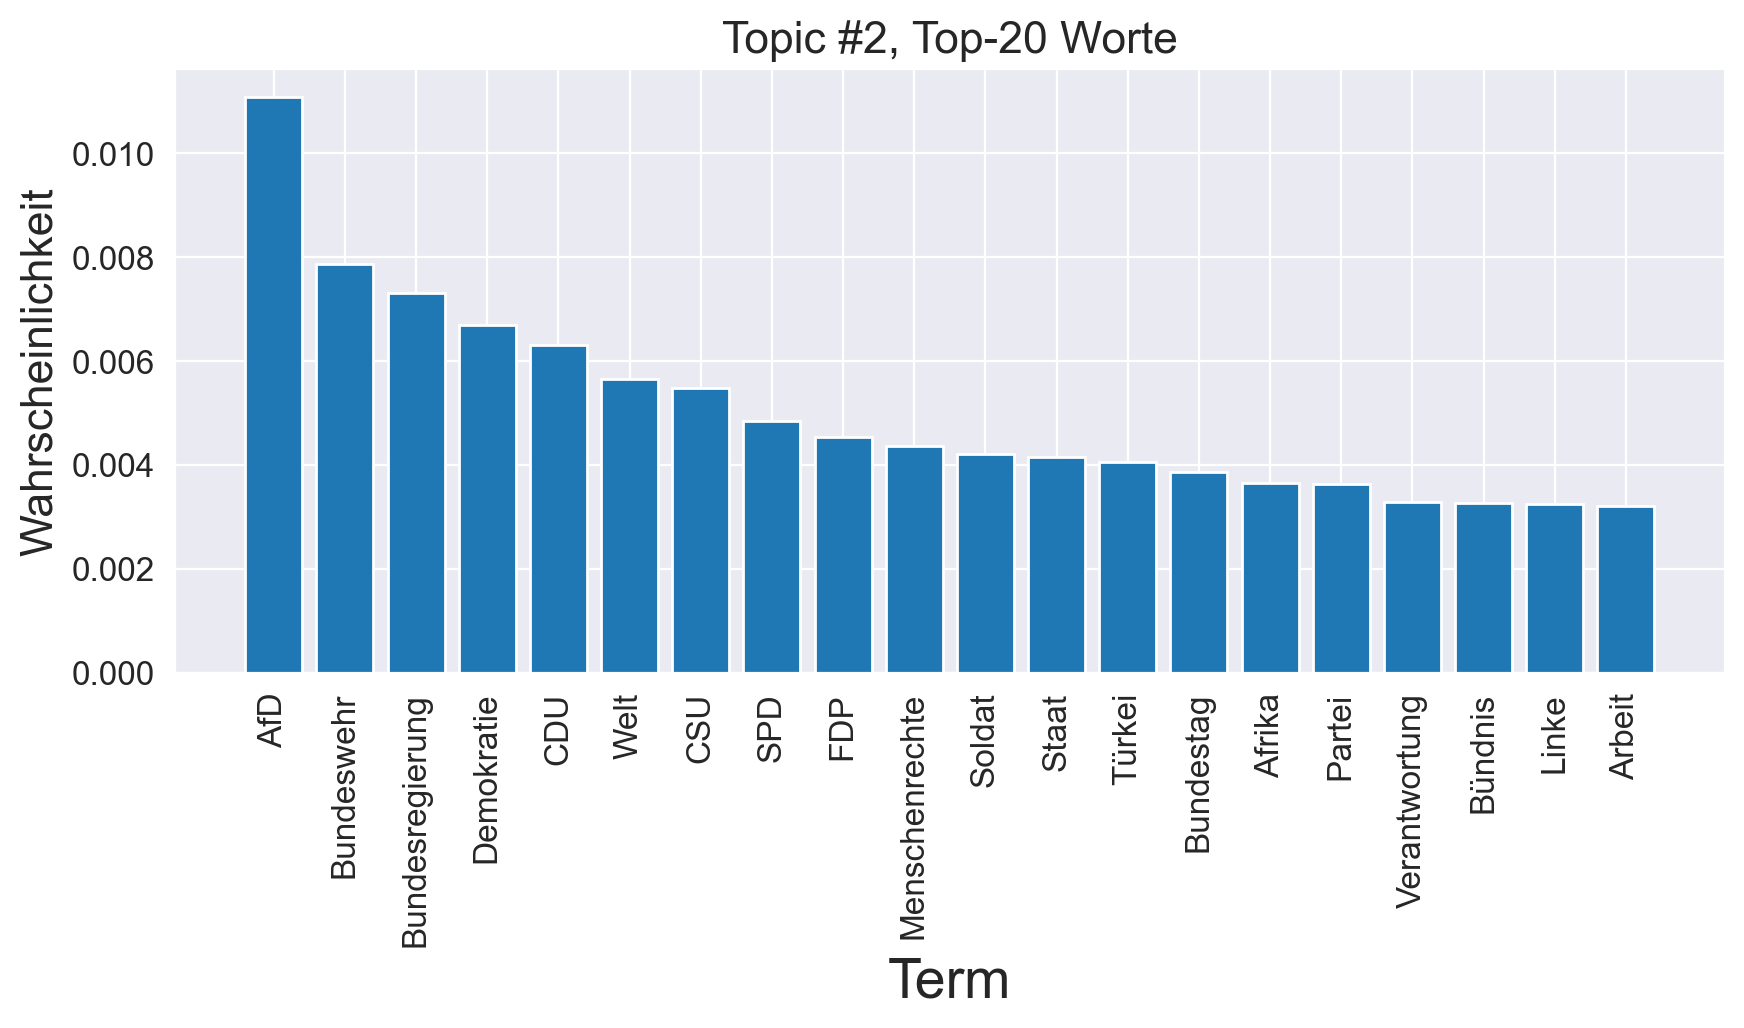

In [23]:
topic_barplot(lda, count_vect.get_feature_names(), 2)

### Topics als Wordclouds

In [24]:
from wordcloud import WordCloud

def topic_cloud(model, feature_names, num_topic, n_top_words = 50, subplot=None):
    
    wc = WordCloud(width=400, height=200, background_color="black", colormap="Paired", max_words=n_top_words) 
    # Generierung der Wordcloud
    wc.generate_from_frequencies(
        dict(show_topic(model, feature_names, num_topic, n_top_words)))

    # Plot
    if subplot:
        plt.subplot(*subplot)
    else:
        fig=plt.figure(figsize=(6, 3))
    plt.tight_layout(pad=0)
    plt.title(f"Topic: {num_topic}", size=10, y=1.05)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

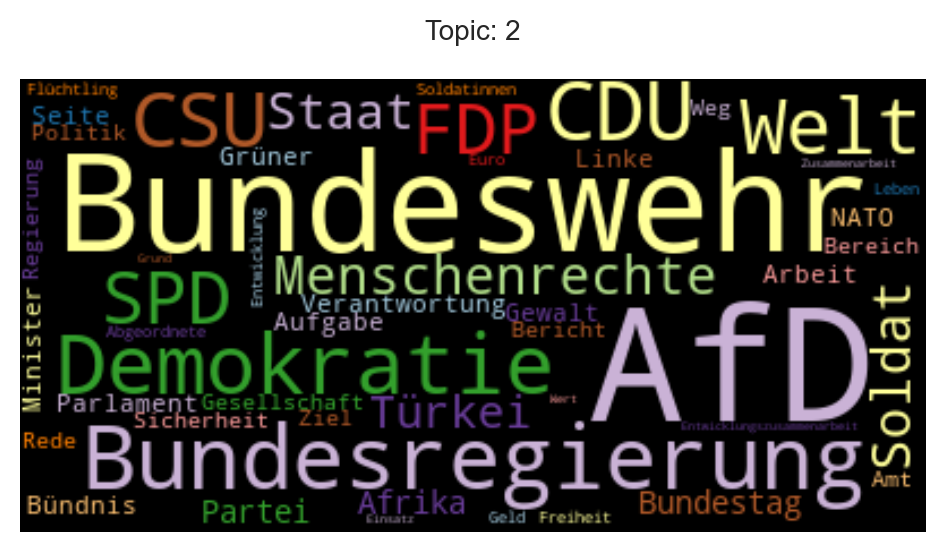

In [25]:
topic_cloud(lda, count_vect.get_feature_names(), 2)

2 5


<Figure size 1000x1200 with 0 Axes>

  0%|          | 0/10 [00:00<?, ?it/s]

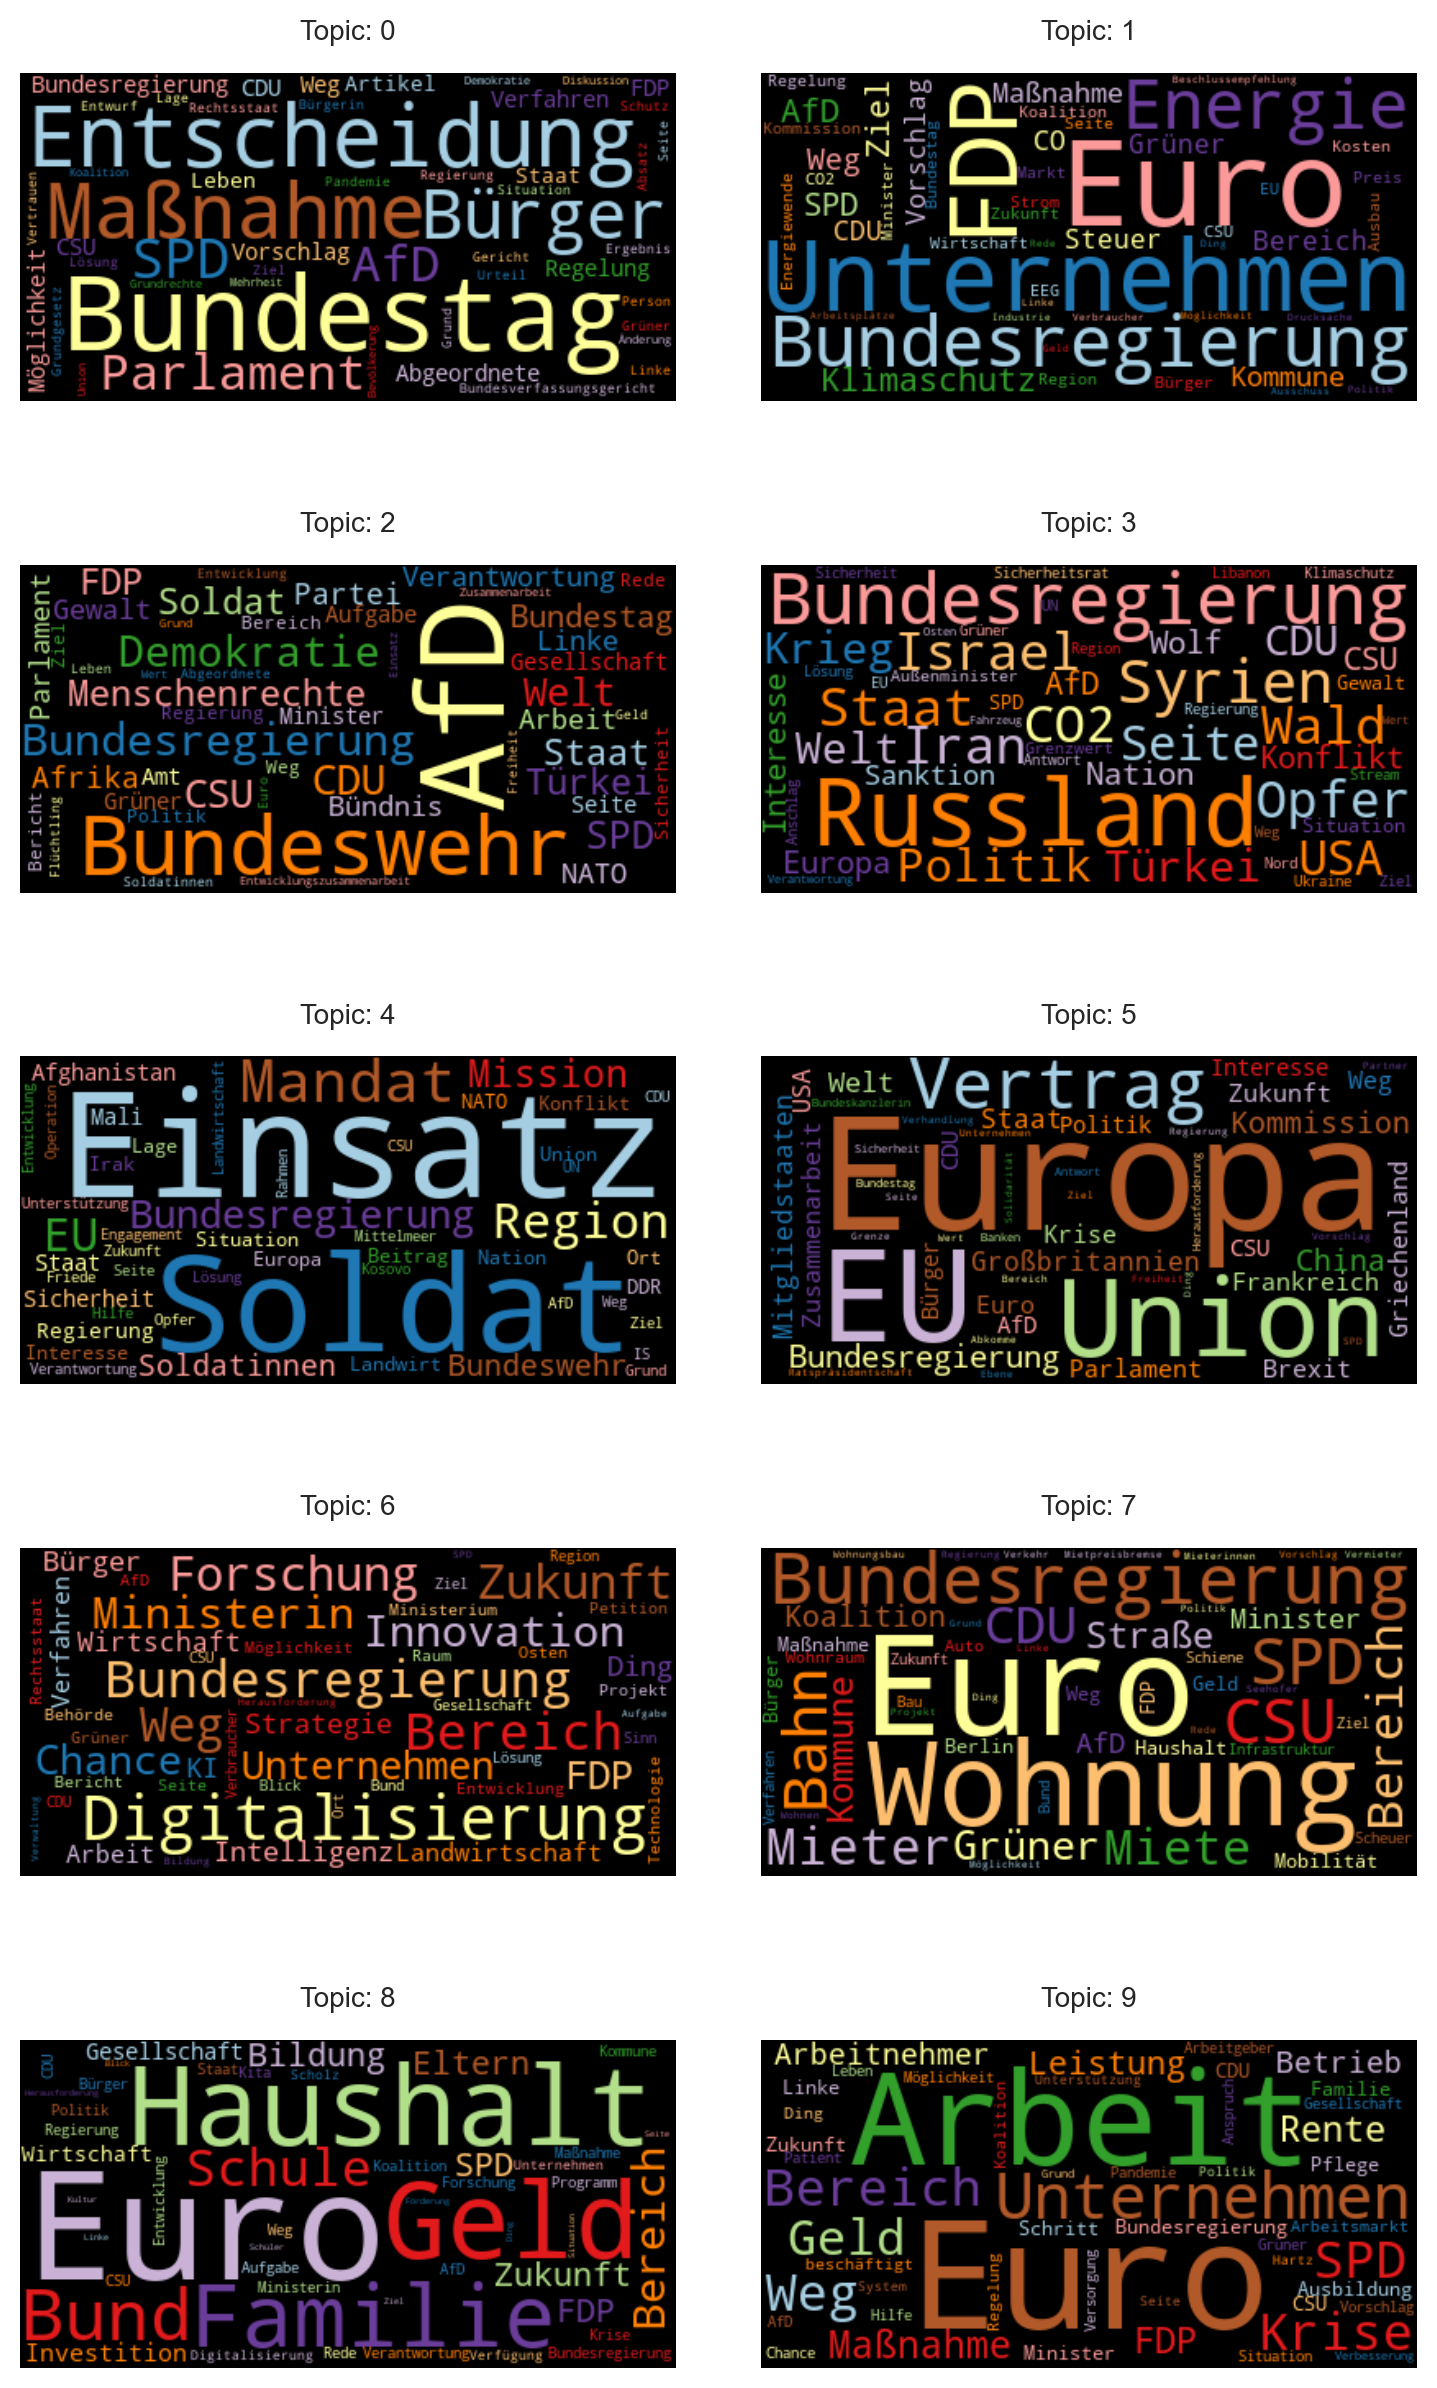

In [26]:
import math

num_topics = lda.n_components

n_cols = 2
n_rows = math.ceil(num_topics/n_cols)
print(n_cols, n_rows)

plt.figure(figsize=(10, 12))
for i in tqdm(range(num_topics)):
    
    subplot = (n_rows, n_cols, i+1)
    topic_cloud(lda, count_vect.get_feature_names(), i, subplot=subplot)
    
# Abstände zwischen den Wordclouds ggf. anpassen
plt.subplots_adjust(hspace=0.5, wspace=-0.4)

###  Topics visualisieren mittels pyLDAvis


In [27]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda, X_tf, count_vect, sort_topics=False)
pyLDAvis.display(lda_display)